# Lab | API wrappers - Create your collection of songs & audio features
### Instructions:
To move forward with the project, you need to create a collection of songs with their audio features - as large as possible!

These are the songs that we will cluster. And, later, when the user inputs a song, we will find the cluster to which the song belongs and recommend a song from the same cluster. The more songs you have, the more accurate and diverse recommendations you'll be able to give. Although... you might want to make sure the collected songs are "curated" in a certain way. Try to find playlists of songs that are diverse, but also that meet certain standards.

The process of sending hundreds or thousands of requests can take some time - it's normal if you have to wait a few minutes (or, if you're ambitious, even hours) to get all the data you need.

An idea for collecting as many songs as possible is to start with all the songs of a big, diverse playlist and then go to every artist present in the playlist and grab every song of every album of that artist. The amount of songs you'll be collecting per playlist will grow exponentially!

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import random
from sklearn.cluster import KMeans

## Top 100 songs and their respective artists

In [2]:
url = 'https://www.billboard.com/charts/hot-100'
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

artists = soup.find_all('span',{'class':re.compile('c-label a-no-trucate')})
songs = soup.find_all('h3',{'class':re.compile('c-title a-no-trucate')})

artists = [x.text.strip() for x in artists]
songs = [x.text.strip() for x in songs]

billboard = pd.DataFrame({"artist":artists,"song":songs})

In [3]:
from getpass import getpass
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')

client_id = 'a34d692f40ab4e5a85b82b474dae7585'
client_secret = '9741f7c35183468fb8e6ceec84621d7d'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
def get_tracks_of_playlist(playlist_id):
    playlist = sp.user_playlist_tracks("spotify", playlist_id)
    tracks = []
    while playlist:
        tracks.extend(playlist['items'])
        if playlist['next']:
            playlist = sp.next(playlist)
        else:
            playlist = None
    return [track['track'] for track in tracks]

def get_audio_features(tracks):
    def get_track_name(track):
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        
        return f'{artist_name} - {track_name}'
    
    audio_features = []
    
    for i in range(0, len(tracks), 100):
        current_tracks = tracks[i:i+100]
        track_names = {track['id']:get_track_name(track) 
                       for track in current_tracks
                       if track}
        
        uris = [track['uri'] 
                for track in current_tracks
                if track]
        
        current_features = sp.audio_features(uris)
        
        for feature in current_features:
            feature['track_name'] = track_names[feature['id']]
        
        audio_features.extend(current_features)
    
    feature_columns = [
        'track_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
    ]
    
    return pd.DataFrame(audio_features)[feature_columns]


def get_song_cluster(song_name: str, scaler, kmeans):
    result = sp.search(q=song_name, type='track', limit=1)
    if not result:
        print(f'{song_name} could not be found in Spotify')
    
    song_audio_features = get_audio_features([result['tracks']['items'][0]]).drop('track_name', axis=1)
    song_audio_features_scaled = pd.DataFrame(scaler.transform(song_audio_features))
    
    cluster_id = kmeans.predict(song_audio_features_scaled)[0]
    return cluster_id

def get_a_song_from_cluster(cluster_id, data, kmeans):
    first_index = data[kmeans.labels_ == cluster_id]['track_name'].first_valid_index()
    return data[kmeans.labels_ == cluster_id]['track_name'][first_index]

def recommend(billboard, data, kmeans, scaler):
    song_name = input('Choose a song from Billboard top 100: ')
    if song_name not in list (billboard['song']):
        print('Sorry,this song is not included in the Top 100. Will recommend from Spotify:')
        cluster_id = get_song_cluster(song_name, scaler, kmeans)
        recommended_song = get_a_song_from_cluster(cluster_id, data, kmeans)
    else:
        print('The song has been found in Top 100. Here another song from Top 100.')
        recommended_song = random.choice(billboard['song'])
    
    print(f'Recommended song: {recommended_song}')

In [5]:
playlist_id = '4baaB43M5WpsCu5jksuaVx'
tracks = get_tracks_of_playlist(playlist_id)

In [6]:
data = get_audio_features(tracks)
X = data.drop('track_name', axis=1)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
x_standardized = scaler.transform(X)
x_standardized = pd.DataFrame(x_standardized,columns = X.columns)
x_standardized

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-0.175253,0.151935,1.039411,-0.325435,-1.135028,0.510909,-0.291604,-0.577047,2.268227,-0.451897,-1.275703
1,1.411022,-0.426897,1.039411,0.688567,-1.135028,0.329197,0.167569,-0.577047,0.842936,0.300349,-1.855248
2,1.484375,-1.270340,-1.673799,0.427360,0.881036,0.671242,-0.257562,-0.575872,0.932017,-1.727047,-0.767040
3,0.750838,0.772114,0.135008,2.021101,0.881036,-0.002160,0.119509,-0.577001,-1.010832,1.703931,-1.748347
4,0.750838,0.772114,0.135008,2.021101,0.881036,-0.002160,0.119509,-0.577001,-1.010832,1.703931,-1.748347
...,...,...,...,...,...,...,...,...,...,...,...
1011,1.438529,-1.807827,0.436475,-1.664999,-1.135028,2.135625,-0.245947,-0.424612,-0.003330,-1.589441,-0.258666
1012,1.438529,-1.807827,0.436475,-1.664999,-1.135028,2.135625,-0.245947,-0.424612,-0.003330,-1.589441,-0.258666
1013,-0.120238,0.739037,0.436475,-0.281630,0.881036,-0.680907,-0.345601,2.781472,-0.495055,1.680997,-0.624083
1014,-0.716237,0.234626,-1.673799,-0.049086,0.881036,-0.267245,-0.345591,-0.412219,-0.306204,0.846187,1.365022


## Elbow method showing the optimal K


Text(0.5, 1.0, 'Elbow method showing the optimal K')

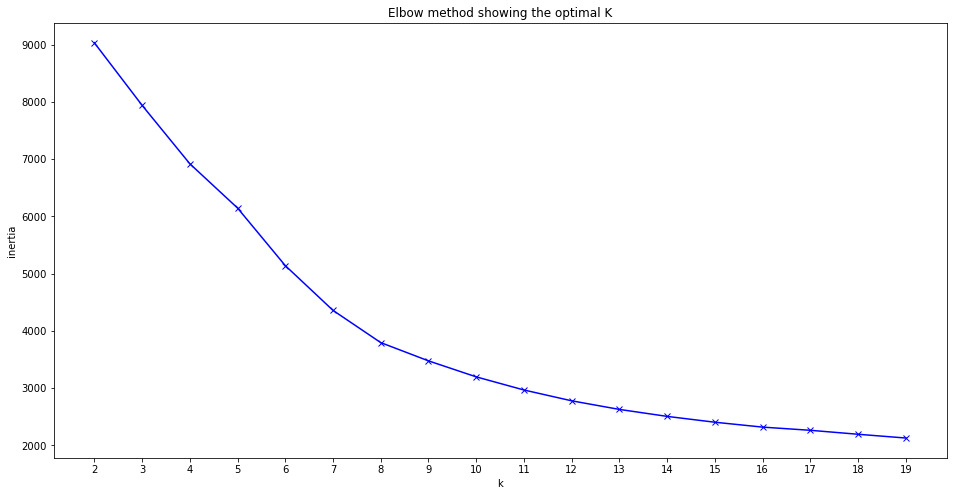

In [8]:
K = range(2,20)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters = k,random_state = 1234)
    kmeans.fit(x_standardized)
    inertia.append(kmeans.inertia_)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize = (16,8))
plt.plot(K,inertia,'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K),max(K)+1,1.0))
plt.title('Elbow method showing the optimal K')


In [9]:
kmeans = KMeans(n_clusters = 8,random_state = 1234)
kmeans.fit(x_standardized)
clusters = kmeans.predict(x_standardized)
pd.Series(clusters).value_counts().sort_index()

0    191
1    254
2     82
3    155
4     67
5    144
6    106
7     17
dtype: int64

In [ ]:
recommend(billboard, data, kmeans, scaler)